## DTSA 5510 Final Project

For my Unsupervised Learning Final Project I wanted to work on a recommender system. I decided to choose a dataset from a repository of Anime shows and movies where users can rate the content on https://myanimelist.net. Based on popularity, genres, and ratings, we can provide recommendations on what customers would most enjoy to watch. 

In [2]:
#Import our necessary packages
import numpy as np
from numpy.linalg import svd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')
import re
import string 
import time
from scipy.sparse import csr_matrix

### Dataset
We will be using data from 73,516 users on 12,294 anime shows and movies from the website https://myanimelist.net. 
I downloaded the dataset from Kaggle: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database

#### Content in Anime.csv
- anime_id: unique id for each anime
- name: full name of anime
- genre: comma separated list of genres for this anime
- type: movie, TV, OVA (original video animation), etc
- episodes: count of episodes in show (if movie, 1)
- rating: average rating out of 10 for this anime
- members: number of community members in the anime's "group"

#### Content in Rating.csv
- user_id: non identifiable randomly generated user id 
- anime_id: the anime that this user has rated
- rating: rating out of 10 this user has assigned (if user watched but didn't rate, -1)

In [3]:
rating = pd.read_csv('/Users/home/Downloads/rating.csv')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
anime = pd.read_csv('/Users/home/Downloads/anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [5]:
print(rating.shape)
print(anime.shape)

(7813737, 3)
(12294, 7)


In [6]:
anime[anime.name == 'Naruto']

,anime_id,name,genre,type,episodes,rating,members
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
#Check for missing values
anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [9]:
rating.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [10]:
#Drop the null values from the anime dataset
anime.dropna(axis=0, inplace=True)
anime.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [11]:
anime.name.unique()

array(['Kimi no Na wa.', 'Fullmetal Alchemist: Brotherhood', 'Gintama°',
       ..., 'Violence Gekiga David no Hoshi',
       'Violence Gekiga Shin David no Hoshi: Inma Densetsu',
       'Yasuji no Pornorama: Yacchimae!!'], dtype=object)

Let's clean the anime name column before we use it for analysis

### Exploratory Data Analysis
Let's draw plots to understand the data

<Axes: xlabel='rating', ylabel='Count'>

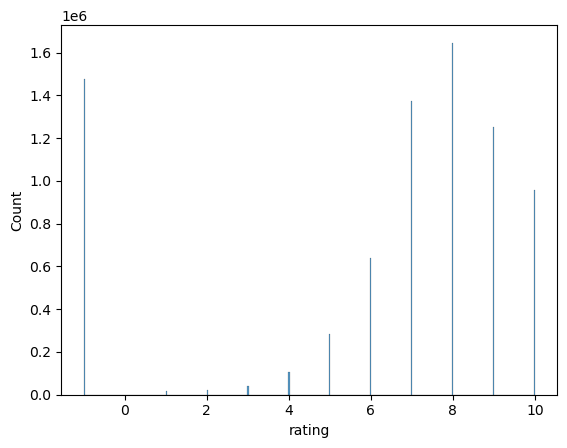

In [12]:
sns.histplot(data=rating, x='rating')

In [13]:
rating.groupby('rating').count()

,user_id,anime_id
rating,,
-1,1476496,1476496
1,16649,16649
2,23150,23150
3,41453,41453
4,104291,104291
5,282806,282806
6,637775,637775
7,1375287,1375287
8,1646019,1646019


In [14]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Anime content that has been watched but not rated has a score of -1. Let's remove this extra noise.

<Axes: xlabel='rating', ylabel='Count'>

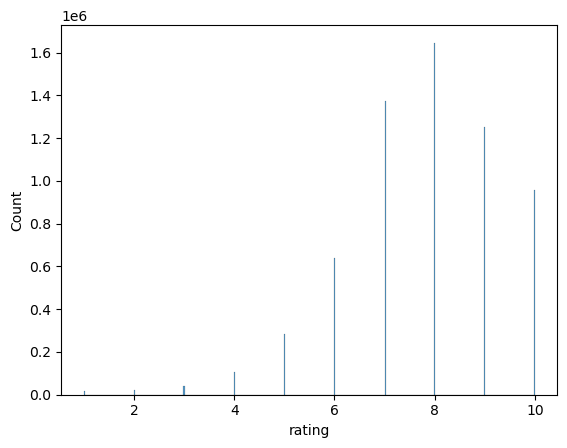

In [15]:
rating = rating.loc[rating['rating'] != -1]
sns.histplot(data=rating, x='rating')

### User-item matrix
Only keep movies that have a minimum number of ratings and users that have provided a minimum number of ratings

In [16]:
user_count = rating.groupby('user_id').count()
user_count = user_count[user_count['anime_id'] >= 50]

anime_count = rating.groupby('anime_id').count()
anime_count = anime_count[anime_count['user_id'] >= 50]

keep_rating = rating[rating['user_id'].isin(user_count.index) &  rating['anime_id'].isin(anime_count.index)]
print(keep_rating.shape)

# Keep only ratings that are in the anime dataset 
keep_rating = keep_rating.merge(anime, on='anime_id')
print(keep_rating.shape)

(5633891, 3)
(5633891, 9)


In [17]:
keep_rating = keep_rating.drop(keep_rating[keep_rating[['user_id', 'anime_id']].duplicated(keep=False)].index, axis=0)

In [18]:
keep_rating = keep_rating.rename(columns={'rating_x': 'rating'})
keep_rating.head()

,user_id,anime_id,rating,name,genre,type,episodes,rating_y,members
0,3,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,5,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
2,21,20,8,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,38,20,6,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,39,20,10,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297


Next, we will convert the remaining rows into a user-item matrix with the user_id in the index and anime_id in the columns and rating as the values

In [19]:
rating_matrix = keep_rating.pivot(index='user_id', columns='anime_id', values='rating').fillna(0)
rating_matrix

anime_id,1,5,6,7,8,15,16,17,18,19,...,33372,33421,33524,33558,33569,33606,33964,34085,34103,34240
user_id,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,8.0,0.0,0.0,6.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73503,9.0,7.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73504,10.0,10.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73507,9.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
def get_animeID_from_index(index):
    return rating_matrix.columns[index]

def get_index_from_animeID(animeID):
    idx = [i for i,x in enumerate(rating_matrix.columns) if x == animeID]
    return idx[0]

### Singular Value Decomposition
We will apply a reduced version of singular value decomposition (SVD) on the user-item matrix. A reduced SVD uses a truncated form of the matrices and thus takes less memory in a computer

In [21]:
matrix = rating_matrix.values
U, s, Vt = svd(matrix, full_matrices=False)
print(f"Left SVD matrix: {U.shape}")
print(f"right SVD matrix: {Vt.shape}")
print(f"SVD matrix: {s.shape}")

Left SVD matrix: (32967, 5172)
right SVD matrix: (5172, 5172)
SVD matrix: (5172,)


Now we will calculate the cosine similarity matrix on the right SVD matrix Vt

In [22]:
cosine_sim = cosine_similarity(Vt)

Find the anime_id with the highest cosine similarity with the given anime_id

In [23]:
def find_most_similar_anime(animeID):
    idx = get_index_from_animeID(animeID)
    similar_anime = list(enumerate(cosine_sim[idx]))
    highest_sim = sorted(similar_anime,key=lambda x: x[1], reverse=True)[1:]
    return_animes = [get_animeID_from_index(i) for i,x in highest_sim[:5]]
    return return_animes

print(find_most_similar_anime(918))


[919, 890, 926, 942, 928]


### Clean up Anime names
We will remove some unwanted characters from the Anime names to find better search results

In [24]:
import re
import sys
import html
import pprint
def clean_text(text):
    text = text.lower()
    text = html.unescape(text)
    encoded_text = text.encode('ascii', errors='ignore')
    text = encoded_text.decode()
    text = re.sub(r'[^\w\s]', '', text)
    return text
anime['name'] = anime['name'].apply(clean_text)
anime[anime['name'] == 'gintama']

,anime_id,name,genre,type,episodes,rating,members
2,28977,gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
4,9969,gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
12,918,gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201,9.04,336376


In [25]:
anime[anime['name'] == 'pokemon']

,anime_id,name,genre,type,episodes,rating,members
1834,527,pokemon,"Action, Adventure, Comedy, Fantasy, Kids",TV,276,7.43,229157


In [26]:
anime.index = anime['anime_id']

def get_anime_id(animeName):
    return anime[anime['name'] == animeName].index

def get_anime_name(animeID):
    return anime["name"].get(animeID)

In [27]:
def print_similar_animes(animeName): 
    animeID_list = get_anime_id(animeName.lower())

    for animeID in animeID_list:
        similar_animes =  find_most_similar_anime(animeID)
        i = 0
        for ID in similar_animes: 
            i += 1
            print(f"Similar Anime #{i}: {get_anime_name(ID)}")

### Test the application

In [28]:
animeName = input("Please enter the Anime name: ")
print_similar_animes(animeName)

Please enter the Anime name: Naruto
Similar Anime #1: mobile suit gundam the 08th ms team
Similar Anime #2: berserk
Similar Anime #3: shuffle
Similar Anime #4: eyeshield 21
Similar Anime #5: ayashi no ceres


### Conclusion
SVD provides a very powerful tool to perform matrix decomposition of the user-item matrix and the resultant matrices provided useful insight into the original matrix. Running pairwise cosine similarity on the right SVD matrix allows us to calculate similarities between movies based on genre, characters, etc. The application executes the content based filtering and displays the top 5 animes with highest cosine similarity.